In [89]:
import json
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from pathlib import Path


import seaborn as sns
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from MulticoreTSNE import MulticoreTSNE as TSNE

# Подготовка данных

In [2]:
def read_ticker(filename):
    filename = Path(filename)
    ticker = filename.name.split('_')[0]
    df = pd.read_json(filename)
    
    return [ticker, df]

In [3]:
data_30 = {}
data_3 = {}
data_1 = {}

for o, filename_template in [[data_30, '*_30.json'], [data_3, '*_3.json'], [data_1, '*_1.json']]:
    for filename in Path('data').glob(filename_template):
        name, data = read_ticker(filename)
        if data.close.std() == 0:
            continue
        data = pd.DataFrame(data)
        o[name] = data


In [4]:
# оставим только ту крипту что есть для всех промежутков
keys = list(set(data_30.keys()).intersection(data_3.keys()).intersection(data_1.keys()))
for data in [data_30, data_3, data_1]:
    key_for_del = list(set(data.keys()).difference(set(keys)))
    for key in key_for_del:
        del(data[key])

In [5]:
# создадим индекс по времени в датафрейме
for ticker in data_1.keys():
    for data in [data_30, data_3, data_1]:
        data[ticker]['time'] = pd.to_datetime(data[ticker]['time'], unit='s')
        data[ticker].set_index('time', inplace=True)


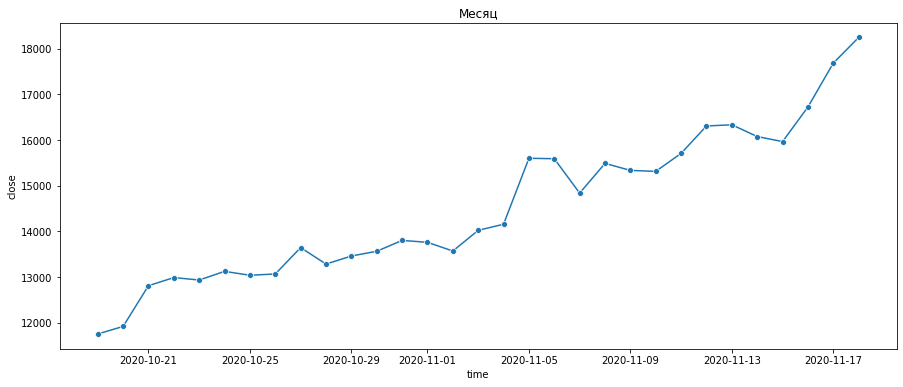

In [88]:
fig, ax = plt.subplots(figsize=(15,6))
sns.lineplot(data=data_30['BTC'], y='close', x=data_30['BTC'].index, ax=ax, marker='o');
ax.set_title('Месяц');

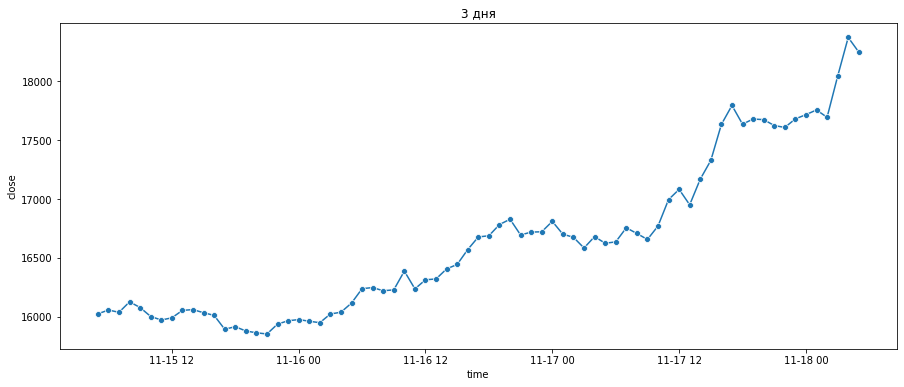

In [87]:
fit, ax = plt.subplots(figsize=(15,6))
sns.lineplot(data=data_3['BTC'], y='close', x=data_3['BTC'].index, ax=ax, marker='o');
ax.set_title('3 дня');

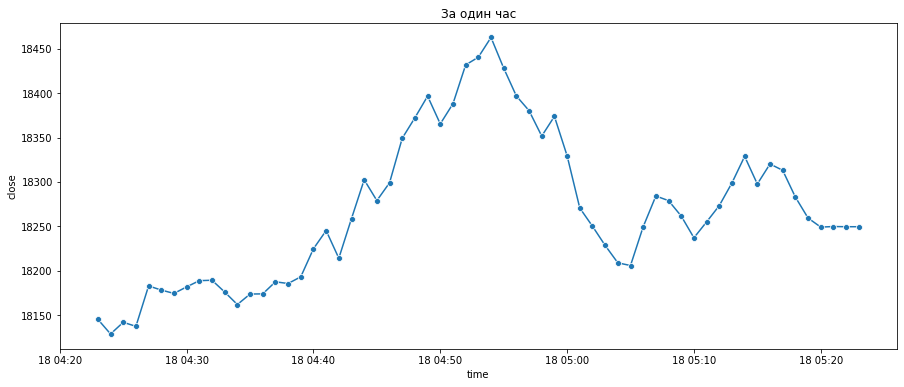

In [86]:
fit, ax = plt.subplots(figsize=(15,6))
sns.lineplot(data=data_1['BTC'], y='close', x=data_1['BTC'].index, ax=ax, marker='o');
ax.set_title('За один час');

In [9]:
tickers_name = list(data_30.keys())
feature = 'close'
index_of_btc = tickers_name.index('BTC')

In [10]:
x_30 = np.empty((0, data_30['BTC'].shape[0]))
x_3 = np.empty((0, data_3['BTC'].shape[0]))
x_1 = np.empty((0, data_1['BTC'].shape[0]))
x_kostyl = {'x_30': x_30, 'x_3': x_3, 'x_1':x_1}

for ticker in tqdm(tickers_name):
    for k, data in [['x_30', data_30], ['x_3', data_3], ['x_1', data_1]]:
        signal = data[ticker][[feature]].to_numpy().swapaxes(0,1)
        x_kostyl[k] = np.vstack([x_kostyl[k], signal])
    x_30 = x_kostyl['x_30']
    x_3 = x_kostyl['x_3']
    x_1 = x_kostyl['x_1']

In [11]:
def get_scaler_data(data):
    scaler = StandardScaler()
    return scaler.fit_transform(data.T).T

In [12]:
x_30 = get_scaler_data(x_30)
x_3 = get_scaler_data(x_3)
x_1 = get_scaler_data(x_1)

# Кластеризация

In [45]:
def plot_distortions(k_range, data, model):
    distortions = []
    K = k_range
    for k in tqdm(K):
        model.set_params(n_clusters=k)
#         kmeanModel = KMeans(n_clusters=k)
        model.fit(data)
        distortions.append(model.inertia_)

    plt.figure(figsize=(12,6))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('Elbow Method')
    plt.show()

## BaseLine Kmeans

### 30 дневный промежуток

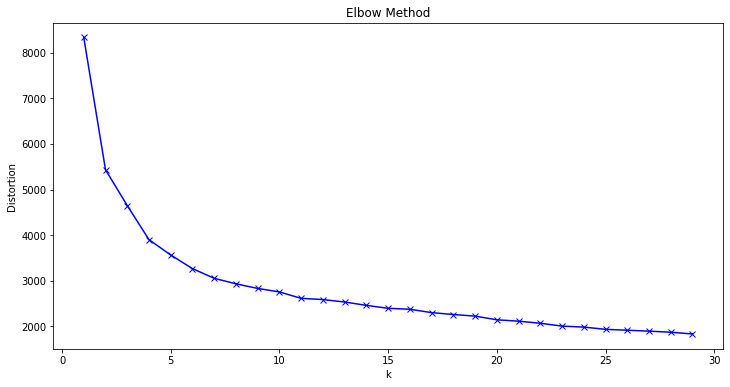

In [46]:
plot_distortions(range(1,20), x_30, KMeans())

In [15]:
model_30 = KMeans(n_clusters=6)
model_30.fit(x_30)

KMeans(n_clusters=6)

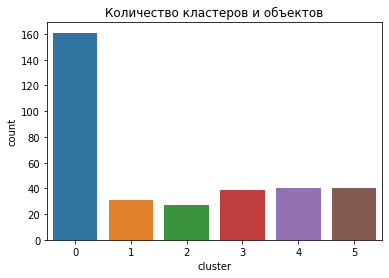

In [16]:
cluster, count = np.unique(model_30.labels_, return_counts=True);
sns.barplot(x=cluster, y=count).set(xlabel='cluster', ylabel='count', title='Количество кластеров и объектов');

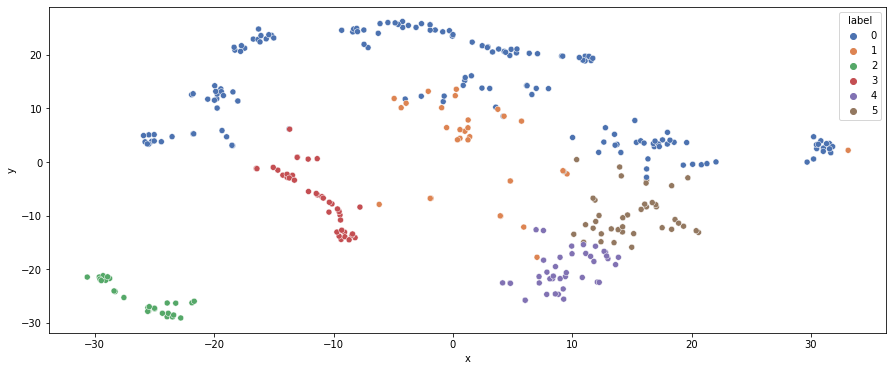

In [17]:
tsne_30 = TSNE(perplexity=10, random_state=32).fit_transform(x_30)
tsne_df_30 = pd.DataFrame({'x':tsne_30[:,0], 'y':tsne_30[:,1], 'label':model_30.labels_})
fig, ax = plt.subplots(figsize=(15,6))
sns.scatterplot(data=tsne_df_30, x='x', y='y', palette="deep", hue='label');

### Крипта похожая на биткойн

In [18]:
def plot_sample_coin(data, labels, mask, title='', figsize=(16, 4)):
    unique_labels = np.unique(labels[mask])
    shape = (len(unique_labels), 3)

    fig, ax = plt.subplots(shape[0], shape[1], figsize=(figsize))
    if len(ax.shape) < 2:
        ax = ax[None,:]
    fig.suptitle(title)
    fig.subplots_adjust(wspace=0, hspace=0.25)
    
    for i, cluster in enumerate(unique_labels):
        coin = np.random.choice(np.where(labels == cluster)[0], size=3, replace=False)
        for ax_i in range(3):
            fig.suptitle(title)
            ax[i, ax_i].plot(data[index_of_btc], 'r', label='BTC')
            ax[i, ax_i].plot(data[coin[ax_i]], 'b--', label=tickers_name[coin[ax_i]])
            ax[i, ax_i].legend(loc='upper left')
            
            ax[i, ax_i].set_title(f"Cluster {cluster}")

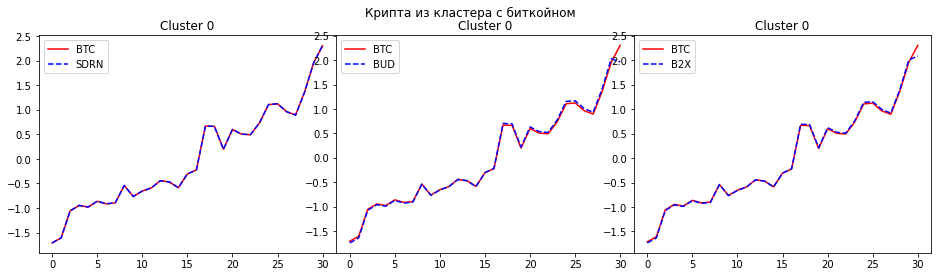

In [22]:
mask = model_30.labels_ == model_30.labels_[index_of_btc]
plot_sample_coin(x_30, model_30.labels_, mask, 'Крипта из кластера с биткойном')

### Примеры крипты попавших в другие кластера

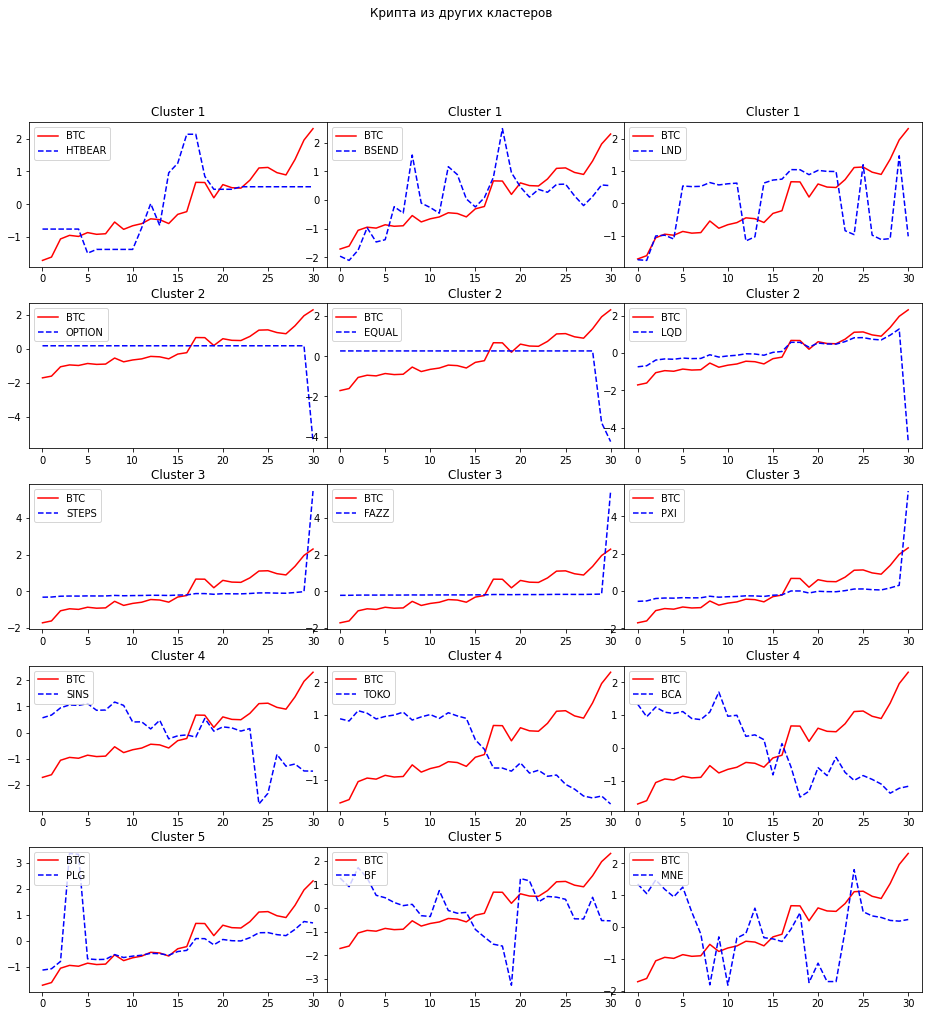

In [23]:
mask = ~mask
plot_sample_coin(x_30, model_30.labels_, mask, 'Крипта из других кластеров', figsize=(16, 16))

### За 3 дня с часовой частотой

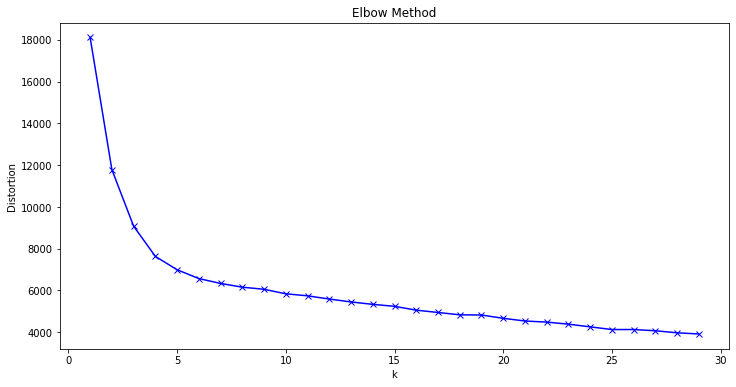

In [24]:
plot_distortions(range(1,20), x_3, KMeans())

In [25]:
model_3 = KMeans(n_clusters=6)
model_3.fit(x_3)

KMeans(n_clusters=6)

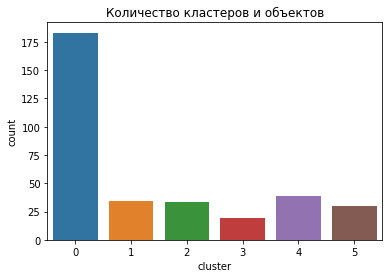

In [26]:
cluster, count = np.unique(model_3.labels_, return_counts=True);
sns.barplot(x=cluster, y=count).set(xlabel='cluster', ylabel='count', title='Количество кластеров и объектов');

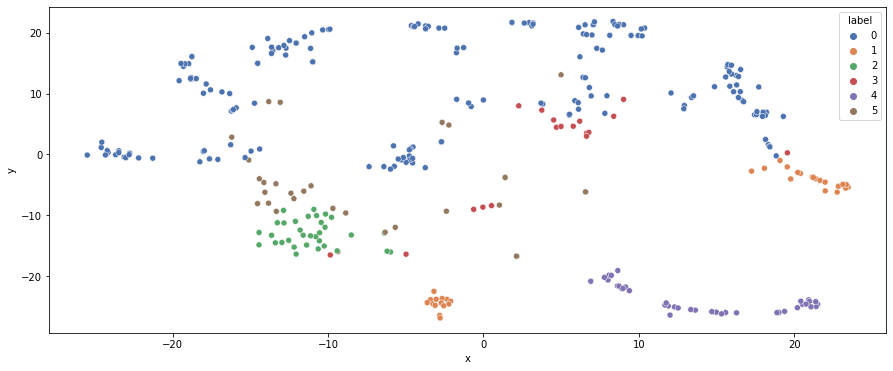

In [27]:
tsne_3 = TSNE(perplexity=10, random_state=32).fit_transform(x_3)
tsne_df_3 = pd.DataFrame({'x':tsne_3[:,0], 'y':tsne_3[:,1], 'label':model_3.labels_})
fig, ax = plt.subplots(figsize=(15,6))
sns.scatterplot(data=tsne_df_3, x='x', y='y', palette="deep", hue='label');

### Крипта похожая на биткойн

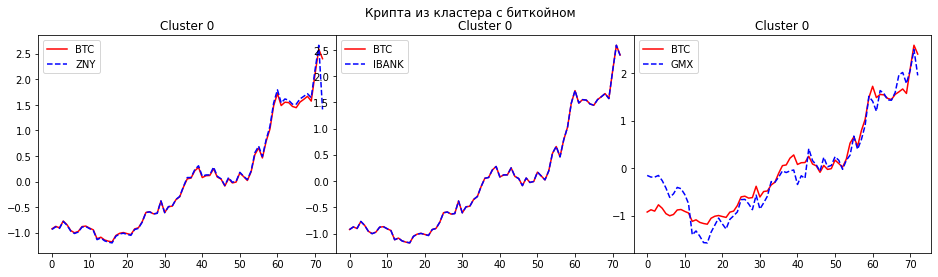

In [28]:
mask = model_3.labels_ == model_3.labels_[index_of_btc]
plot_sample_coin(x_3, model_3.labels_, mask, 'Крипта из кластера с биткойном')

### Примеры крипты попавших в другие кластера

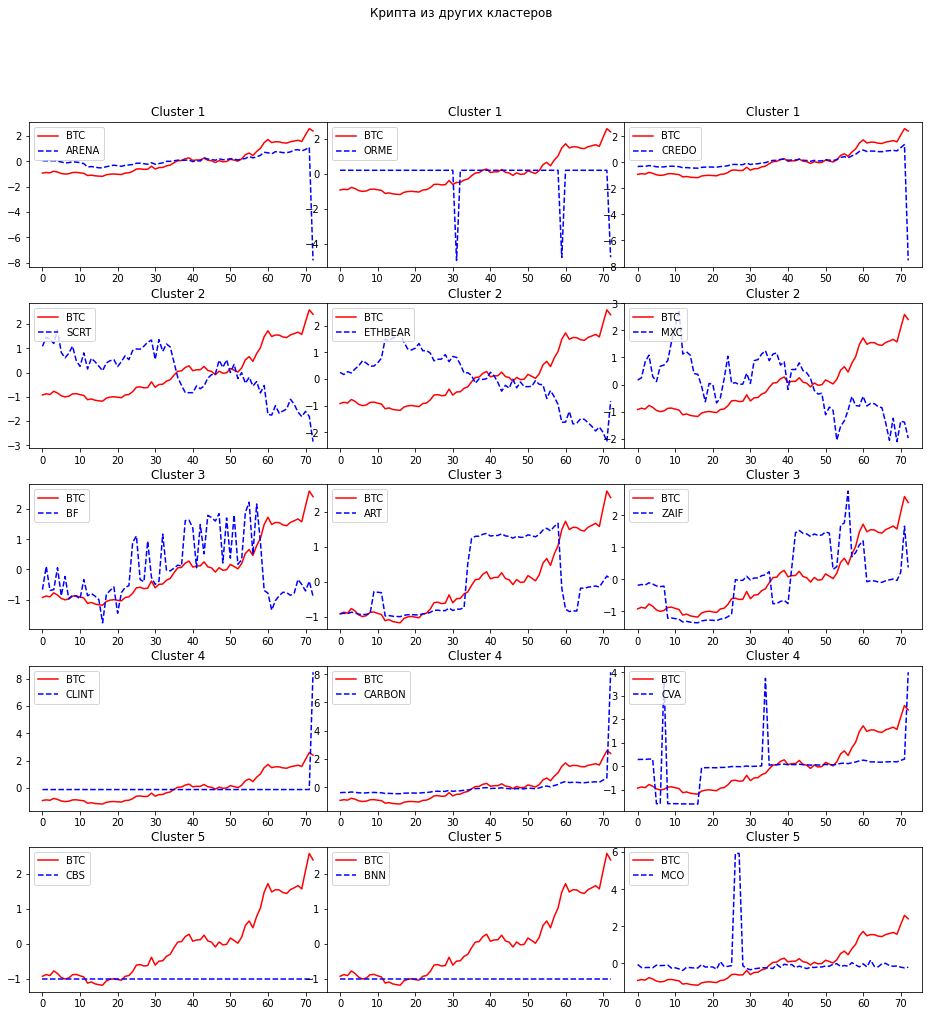

In [29]:
mask = ~mask
plot_sample_coin(x_3, model_3.labels_, mask, 'Крипта из других кластеров', figsize=(16, 16))

### За 1 час с минутной частотой

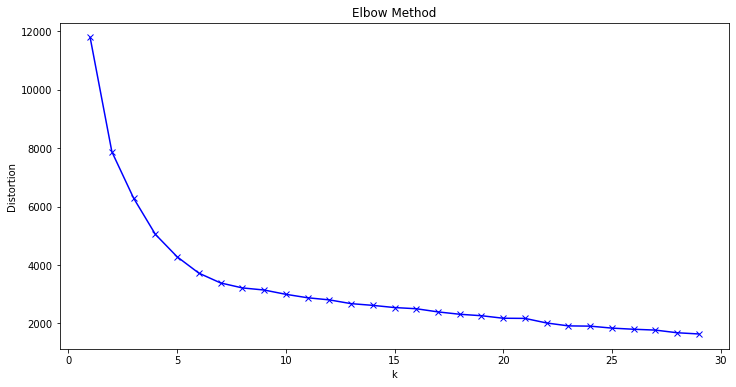

In [30]:
plot_distortions(range(1,20), x_1, KMeans())

In [31]:
model_1 = KMeans(n_clusters=6)
model_1.fit(x_1)

KMeans(n_clusters=6)

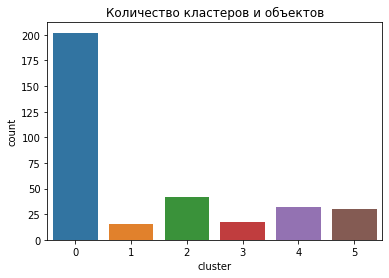

In [32]:
cluster, count = np.unique(model_1.labels_, return_counts=True);
sns.barplot(x=cluster, y=count).set(xlabel='cluster', ylabel='count', title='Количество кластеров и объектов');

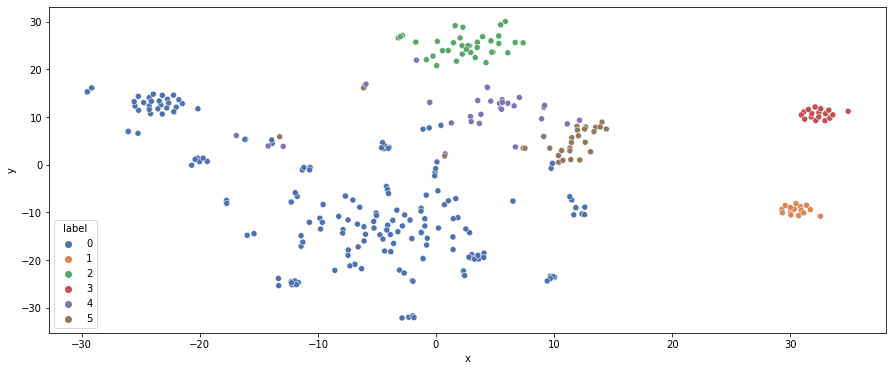

In [33]:
tsne_1 = TSNE(perplexity=10, random_state=32).fit_transform(x_1)
tsne_df_1 = pd.DataFrame({'x':tsne_1[:,0], 'y':tsne_1[:,1], 'label':model_1.labels_})
fig, ax = plt.subplots(figsize=(15,6))
sns.scatterplot(data=tsne_df_1, x='x', y='y', palette="deep", hue='label');

### Крипта похожая на биткойн

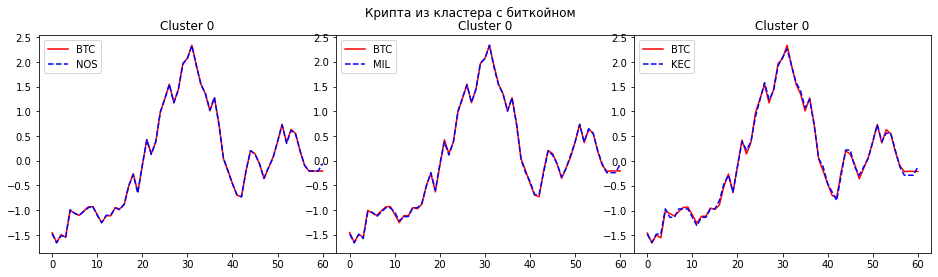

In [34]:
mask = model_1.labels_ == model_1.labels_[index_of_btc]
plot_sample_coin(x_1, model_1.labels_, mask, 'Крипта из кластера с биткойном')

### Примеры крипты попавших в другие кластера

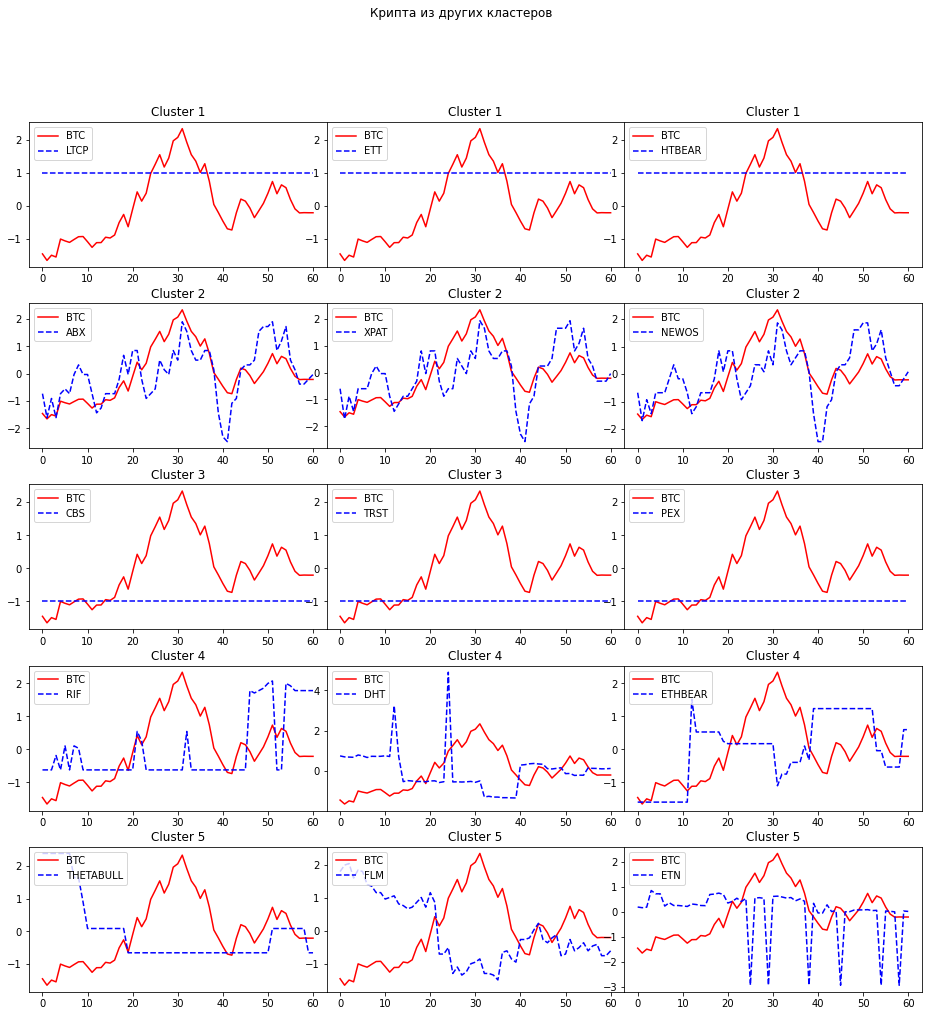

In [35]:
mask = ~mask
plot_sample_coin(x_1, model_1.labels_, mask, 'Крипта из других кластеров', figsize=(16, 16))

## DTW Kmeans

## 30 дневный промежуток

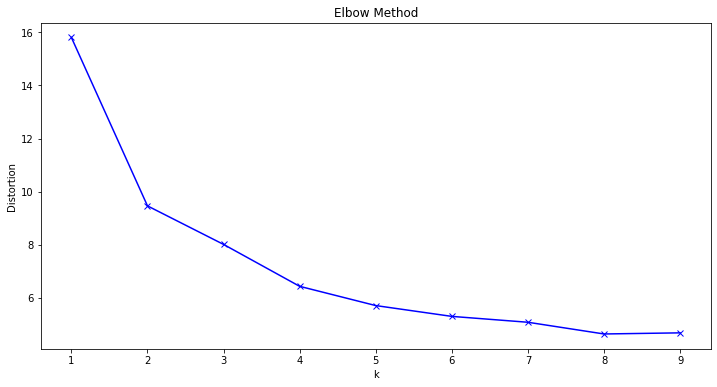

In [52]:
plot_distortions(range(1,10), x_30, TimeSeriesKMeans(metric="dtw", n_jobs=4))

In [53]:
model_30_dtw = TimeSeriesKMeans(n_clusters=4, metric="dtw", n_jobs=4)
model_30_dtw.fit(x_30)

TimeSeriesKMeans(metric='dtw', n_clusters=4, n_jobs=4)

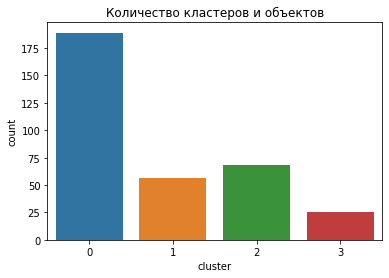

In [54]:
cluster, count = np.unique(model_30_dtw .labels_, return_counts=True);
sns.barplot(x=cluster, y=count).set(xlabel='cluster', ylabel='count', title='Количество кластеров и объектов');

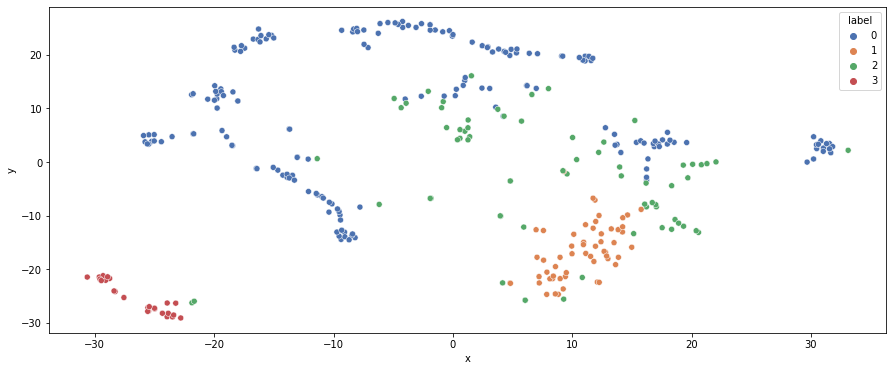

In [57]:
tsne_30_dtw = tsne_30
tsne_df_30_dtw = pd.DataFrame({'x':tsne_30_dtw[:,0], 'y':tsne_30_dtw[:,1], 'label':model_30_dtw.labels_})
fig, ax = plt.subplots(figsize=(15,6))
sns.scatterplot(data=tsne_df_30_dtw, x='x', y='y', palette="deep", hue='label');

### Крипта похожая на биткойн

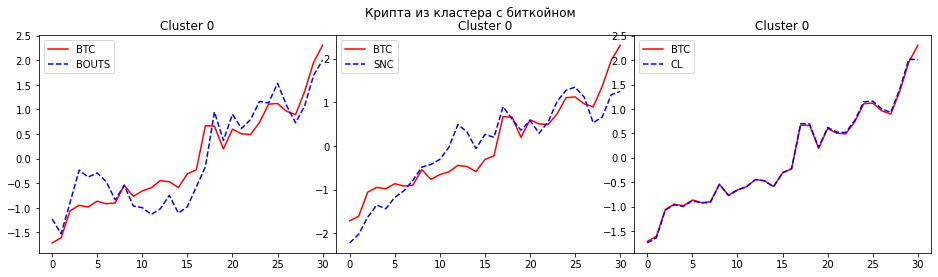

In [59]:
mask = model_30_dtw.labels_ == model_30_dtw.labels_[index_of_btc]
plot_sample_coin(x_30, model_30_dtw.labels_, mask, 'Крипта из кластера с биткойном')

### Примеры крипты попавших в другие кластера

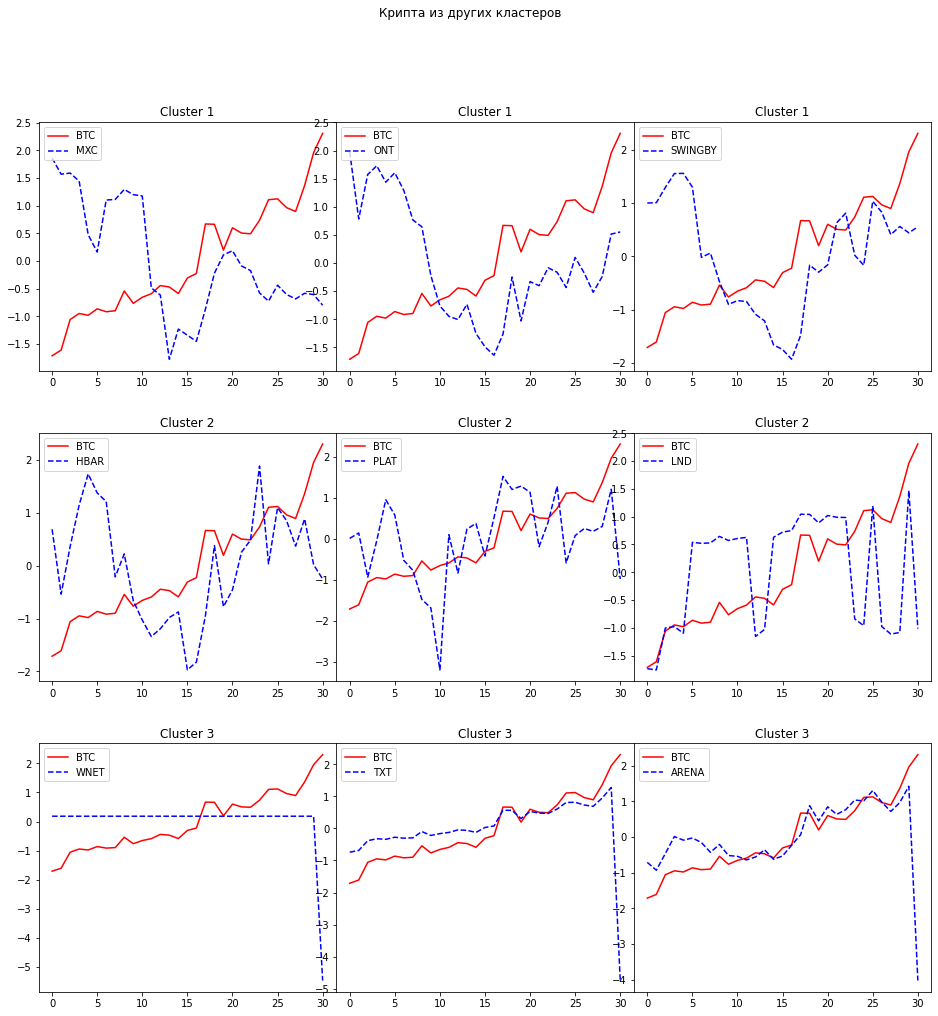

In [60]:
mask = ~mask
plot_sample_coin(x_30, model_30_dtw.labels_, mask, 'Крипта из других кластеров', figsize=(16, 16))

### За 3 дня с часовой частотой

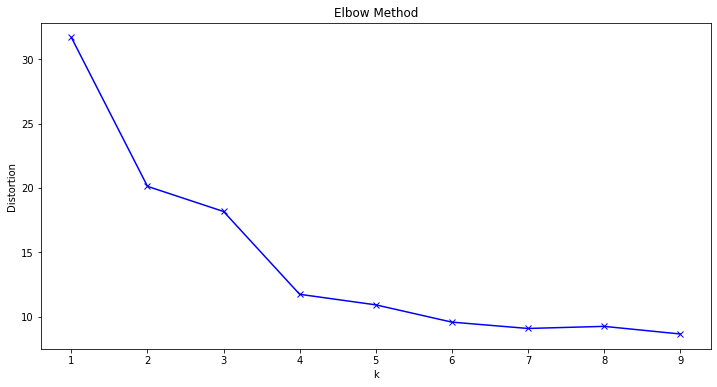

In [61]:
plot_distortions(range(1,10), x_3, TimeSeriesKMeans(metric="dtw", n_jobs=4))

In [62]:
model_3_dtw = TimeSeriesKMeans(n_clusters=4, metric="dtw", n_jobs=4)
model_3_dtw.fit(x_3)

TimeSeriesKMeans(metric='dtw', n_clusters=4, n_jobs=4)

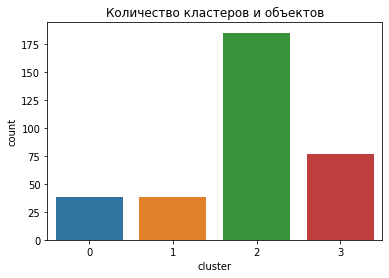

In [63]:
cluster, count = np.unique(model_3_dtw .labels_, return_counts=True);
sns.barplot(x=cluster, y=count).set(xlabel='cluster', ylabel='count', title='Количество кластеров и объектов');

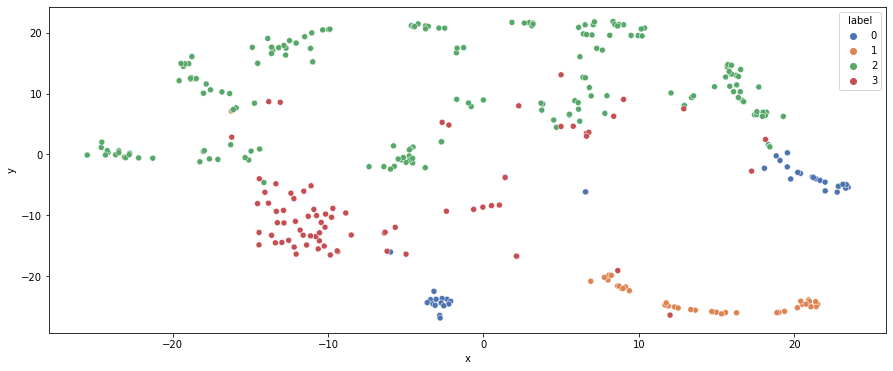

In [64]:
tsne_3_dtw = tsne_3
tsne_df_3_dtw = pd.DataFrame({'x':tsne_3_dtw[:,0], 'y':tsne_3_dtw[:,1], 'label':model_3_dtw.labels_})
fig, ax = plt.subplots(figsize=(15,6))
sns.scatterplot(data=tsne_df_3_dtw, x='x', y='y', palette="deep", hue='label');

### Крипта похожая на биткойн

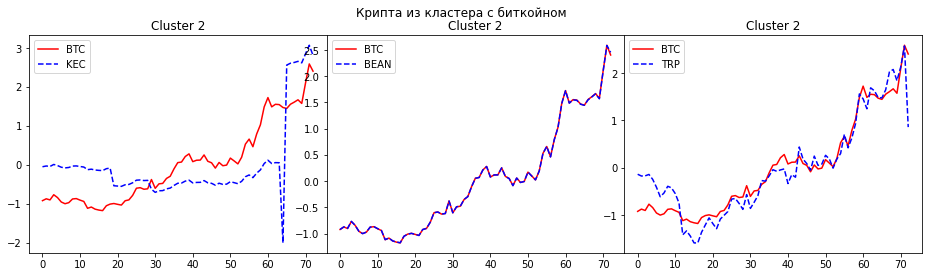

In [65]:
mask = model_3_dtw.labels_ == model_3_dtw.labels_[index_of_btc]
plot_sample_coin(x_3, model_3_dtw.labels_, mask, 'Крипта из кластера с биткойном')

### Примеры крипты попавших в другие кластера

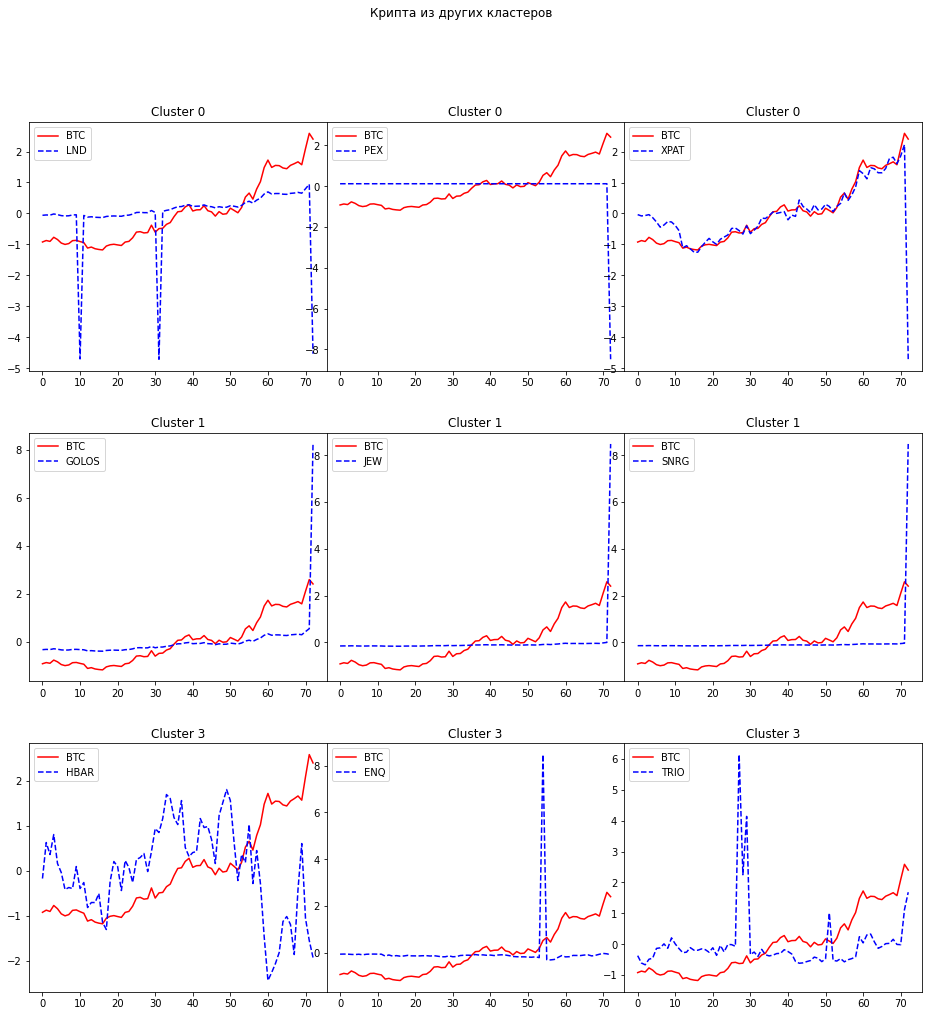

In [67]:
mask = ~mask
plot_sample_coin(x_3, model_3_dtw.labels_, mask, 'Крипта из других кластеров', figsize=(16, 16))

### За 1 час с минутной частотой

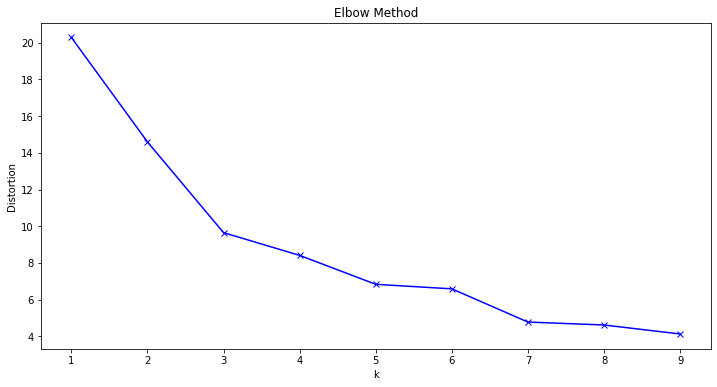

In [68]:
plot_distortions(range(1,10), x_1, TimeSeriesKMeans(metric="dtw", n_jobs=4))

In [81]:
model_1_dtw = TimeSeriesKMeans(n_clusters=4, metric="dtw", n_jobs=4)
model_1_dtw.fit(x_1)

TimeSeriesKMeans(metric='dtw', n_clusters=4, n_jobs=4)

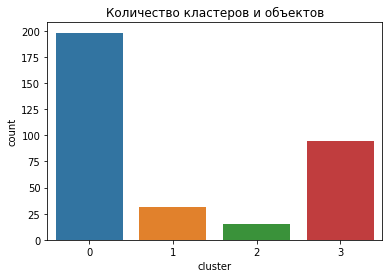

In [82]:
cluster, count = np.unique(model_1_dtw .labels_, return_counts=True);
sns.barplot(x=cluster, y=count).set(xlabel='cluster', ylabel='count', title='Количество кластеров и объектов');

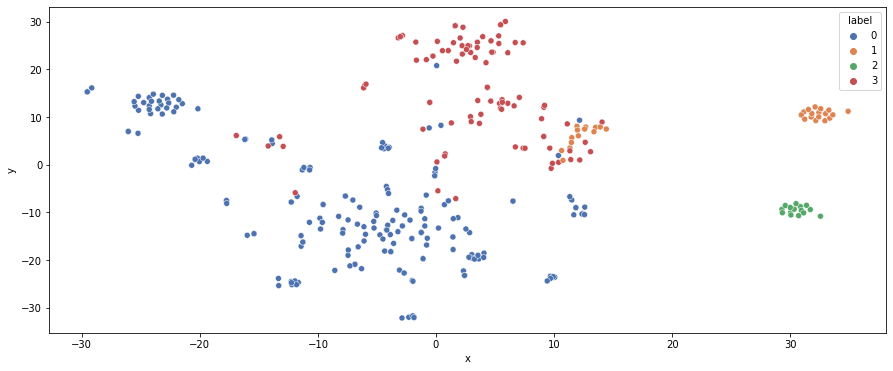

In [83]:
tsne_1_dtw = tsne_1
tsne_df_1_dtw = pd.DataFrame({'x':tsne_1_dtw[:,0], 'y':tsne_1_dtw[:,1], 'label':model_1_dtw.labels_})
fig, ax = plt.subplots(figsize=(15,6))
sns.scatterplot(data=tsne_df_1_dtw, x='x', y='y', palette="deep", hue='label');

### Крипта похожая на биткойн

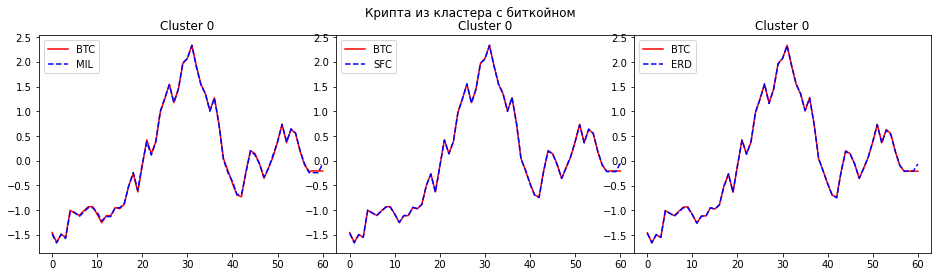

In [84]:
mask = model_1_dtw.labels_ == model_1_dtw.labels_[index_of_btc]
plot_sample_coin(x_1, model_1_dtw.labels_, mask, 'Крипта из кластера с биткойном')

### Примеры крипты попавших в другие кластера

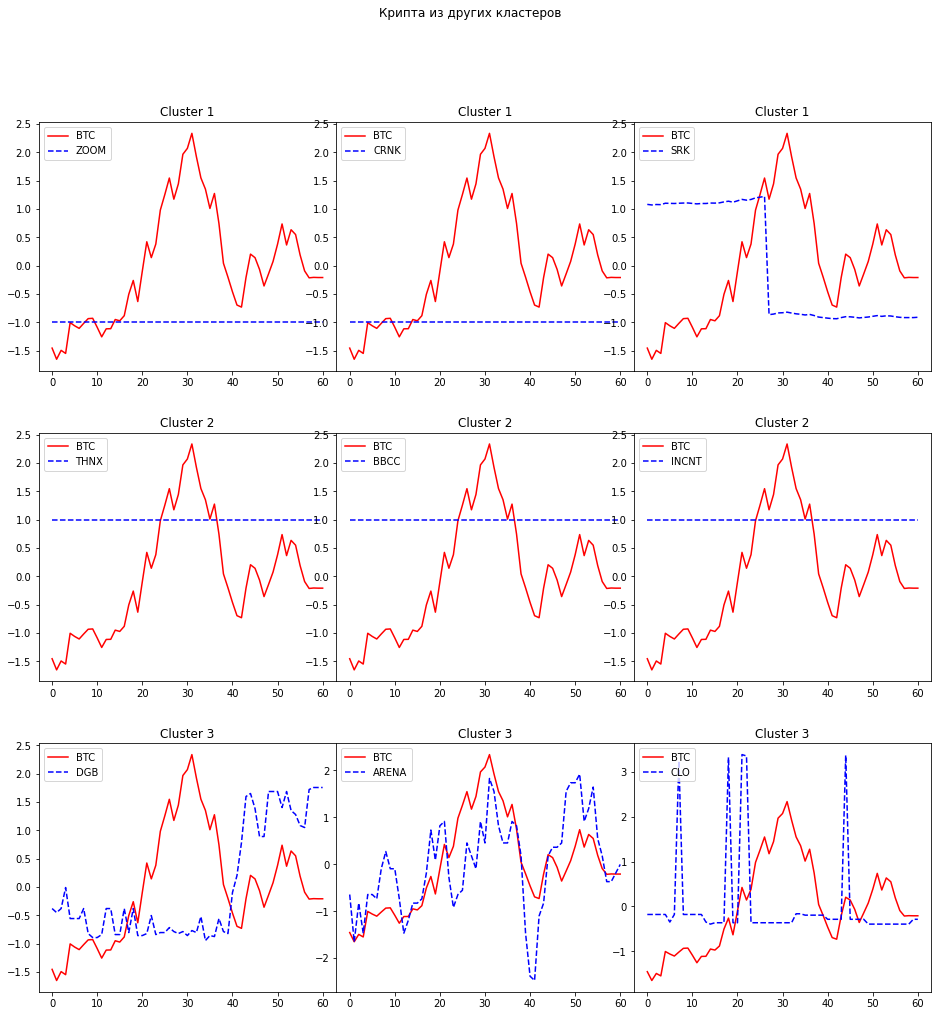

In [85]:
mask = ~mask
plot_sample_coin(x_1, model_1_dtw.labels_, mask, 'Крипта из других кластеров', figsize=(16, 16))